In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import pickle

import numpy as np
import pytest
import torch
import veccs.orderings

import matplotlib.pyplot as plt
from batram.legmods import Data, SimpleTM


/Users/paulwiemann/projects/mv-batram/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load and prep data

data_fp = pathlib.Path("../tests/data/simNR900.pkl").absolute()
with open(data_fp, "rb") as fh:
    data_pkl: dict[str, np.ndarray] = pickle.load(fh)

locs = data_pkl["locations"]
obs = data_pkl["observations"]

# use only a subset of the available ensemble
obs = obs[:10, :]

# create data object
# this method will also order the data
max_size_cs = 20
data = Data.new_from_unordered(locs, obs, max_size_cs)
theta_init = torch.tensor(
    [data.response[:, 0].square().mean().log(), 0.2, 0.0, 0.0, 0.0, -1.0]
)


In [4]:
# use default optimizer with default scheduler
nsteps = 200
init_step_size = 0.3
tm = SimpleTM(data, theta_init.clone(), False, smooth=1.5, nugMult=4.0)
res = tm.fit(nsteps, 0.1)

Train Loss: 10053.826: 100%|██████████| 200/200 [00:04<00:00, 43.33it/s]


In [5]:
# user-defined optimizer with user-defined scheduler
# when using a user-defined optimizer, the argument init_lr is ignored
# use minibatch
# track test loss (loss on the full dataset, can be expensive to compute)

nsteps = 200
tm = SimpleTM(data, theta_init.clone(), False, smooth=1.5, nugMult=4.0)
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=128)

Train Loss: 10055.692, Test Loss: 10053.258: 100%|██████████| 200/200 [00:08<00:00, 23.94it/s]


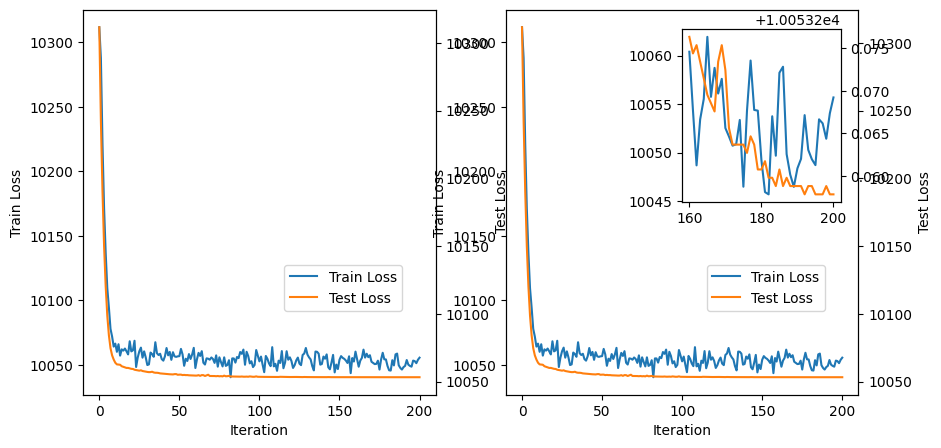

In [6]:
# plot loss

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
res.plot_loss(axs[0], use_inset=False)
res.plot_loss(axs[1], use_inset=True)
plt.show()

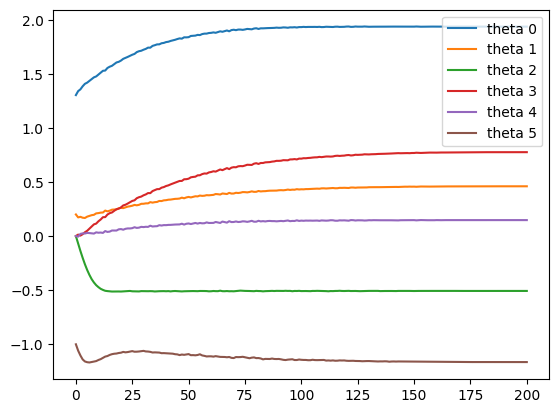

In [7]:
# plot tracked parameters
plt.plot(res.param_chain['theta.theta'], label=[f"theta {i}" for i in range(6)])
plt.legend()
plt.show()

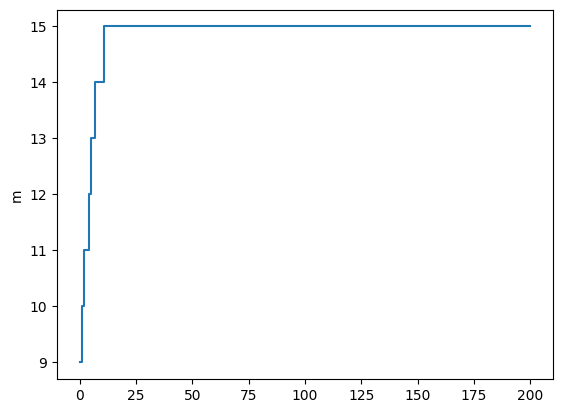

In [8]:
# plot tracked values
xiter = torch.arange(len(res.tracked_chain['transport_map_kernel.m']))
plt.step(xiter, res.tracked_chain['transport_map_kernel.m'])
plt.ylabel("m")
plt.show()